# Github Metrics- Activity by Repo 

This notebook will aim to query the Augur DB to access the neccessary information to be able to get the following metrics dirived from the GitHub Community Metrics working document https://docs.google.com/document/d/1Yocr6fk0J8EsVZnJwoIl3kRQaI94tI-XHe7VSMFT0yM/edit?usp=sharing

Any necessary computations from the data to get the metric value will be done as the queries are determined|

In [1]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import json
import os
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 5)

with open("../config_temp.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Control Cell - Set Variables and Filters 

The cell below is for generating repo_ids from the repo names. For this to work, the repo must already be in the database. If you want to manually assign a repo_id skip the cell below and read the comments on the next cell.

In [3]:
#add your repo name(s) here of the repo(s) you want to query if known (and in the database)
repo_name_set = ['augur', 'grimoirelab']
repo_set = []

for repo_name in repo_name_set:
    repo_query = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                 SELECT 
                    b.repo_id
                FROM
                    repo_groups a,
                    repo b
                WHERE
                    a.repo_group_id = b.repo_group_id AND
                    b.repo_name = \'{repo_name}\'
        """)

    t = engine.execute(repo_query)
    repo_id =t.mappings().all()[0].get('repo_id')
    repo_set.append(repo_id)
print(repo_set)

[25440, 25448]


In [4]:
#Take this out of quotes if you want to manually assign a repo_id number(s)
#repo_set = [25440]

## Query for commit analysis

It should be noted that each entry on this table is for files, not commits. So there can be multiple files/rows for each commits  

In [5]:
df_commits = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    r.repo_name,
                    c.cmt_commit_hash AS commits,
                    c.cmt_id AS file, 
					c.cmt_added AS lines_added,
					c.cmt_removed AS lines_removed,
                    c.cmt_author_date AS date, 
                    c.cmt_author_timestamp AS time_stamp
                FROM
                	repo r,
                    commits c
                WHERE
                	r.repo_id = c.repo_id AND
                    c.repo_id = \'{repo_id}\'
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_commits = pd.concat([df_commits, df_current_repo])

df_commits = df_commits.reset_index()
df_commits.drop("index", axis=1, inplace=True)
        
df_commits

,repo_name,commits,file,lines_added,lines_removed,date,time_stamp
0,augur,79ee6429a570b2982fab12a20dea670a858e1141,34605744,2,2,2021-03-24,2021-03-24 16:47:14+01:00
1,augur,79ee6429a570b2982fab12a20dea670a858e1141,34605745,1,1,2021-03-24,2021-03-24 16:47:14+01:00
2,augur,574901f5cd8372006cc64ff2b9f14f5470bba4e4,34605767,6,6,2021-03-19,2021-03-19 07:21:06+01:00
3,augur,7877b0c7937c6242e18ed712d5fb14323d13115f,34605778,2,2,2021-03-24,2021-03-24 16:06:07+01:00
4,augur,7877b0c7937c6242e18ed712d5fb14323d13115f,34605779,1,1,2021-03-24,2021-03-24 16:06:07+01:00
...,...,...,...,...,...,...,...
27673,grimoirelab,fe7ab96bdf7d0187737285af6dc3c08f5c422f14,34556304,6,2,2018-01-19,2018-01-19 01:01:41+01:00
27674,grimoirelab,ff18ee3474f147c6c3b99997ac79b612fd7a2adc,34556713,2,2,2018-06-04,2018-06-04 00:05:02+02:00
27675,grimoirelab,ff22f21630e80b67707db0551ca1787de843e403,34556365,1,1,2018-09-10,2018-09-10 21:02:37+02:00
27676,grimoirelab,ff7bd07014362d6b1b54a7c4de6e70e8412ee1d0,34557194,15,0,2019-04-01,2019-04-01 10:52:44+02:00


### Number of commits (by hour/day/week)

In [6]:
# We will fetch all the unique commit IDs and drop the redundant ones
df_commits_unique = df_commits.drop_duplicates(subset=['commits'])

In [7]:
# Fetch the commits for the `augur` repo
df_commits_augur = df_commits_unique[df_commits_unique['repo_name'] == 'augur']
df_commits_augur = df_commits_augur.reset_index(drop=True)

In [8]:
df_commits_augur.head()

,repo_name,commits,file,lines_added,lines_removed,date,time_stamp
0,augur,79ee6429a570b2982fab12a20dea670a858e1141,34605744,2,2,2021-03-24,2021-03-24 16:47:14+01:00
1,augur,574901f5cd8372006cc64ff2b9f14f5470bba4e4,34605767,6,6,2021-03-19,2021-03-19 07:21:06+01:00
2,augur,7877b0c7937c6242e18ed712d5fb14323d13115f,34605778,2,2,2021-03-24,2021-03-24 16:06:07+01:00
3,augur,4e131ee62c69324dfd9bb98e12164574534113f8,34601431,0,0,2020-06-23,2020-06-23 20:50:37+02:00
4,augur,60af48b1e5a7229d5bc97d02a11144f7486bfb7a,34601429,0,0,2020-06-18,2020-06-18 19:57:47+02:00


In [9]:
# Let's find the number of commits made per day in the `augur` repo
augur_daily_commits = pd.DataFrame(df_commits_augur['commits'].groupby(df_commits_augur["date"]).count())

In [10]:
augur_daily_commits.head()

,commits
date,
2017-01-05,1
2017-01-10,5
2017-01-11,1
2017-01-12,1
2017-01-18,4


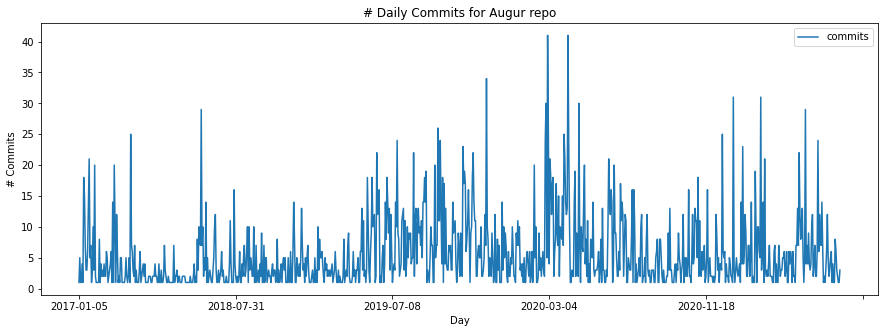

In [11]:
augur_daily_commits.plot()

plt.xlabel("Day")
plt.ylabel("# Commits")
plt.title("# Daily Commits for Augur repo")
plt.show()

### Number of lines per commit

In [12]:
df_lines_augur = pd.DataFrame(df_commits_augur['lines_added'].groupby(df_commits_augur['commits']).sum())
df_lines_augur.head()

,lines_added
commits,
0005db68a59e3052c5bedb1c0b8862654e9707e3,4
0018b38ff01dfe5f32689d457b7dd7e0ef1e27fb,0
0024f4e92b2171abe71d6de77001024df2998239,6
002b7f992e9afbd21a3a5f481ef79fffa992a0f7,3
0032a5ad92449df87e060391a502f7c65559c249,2


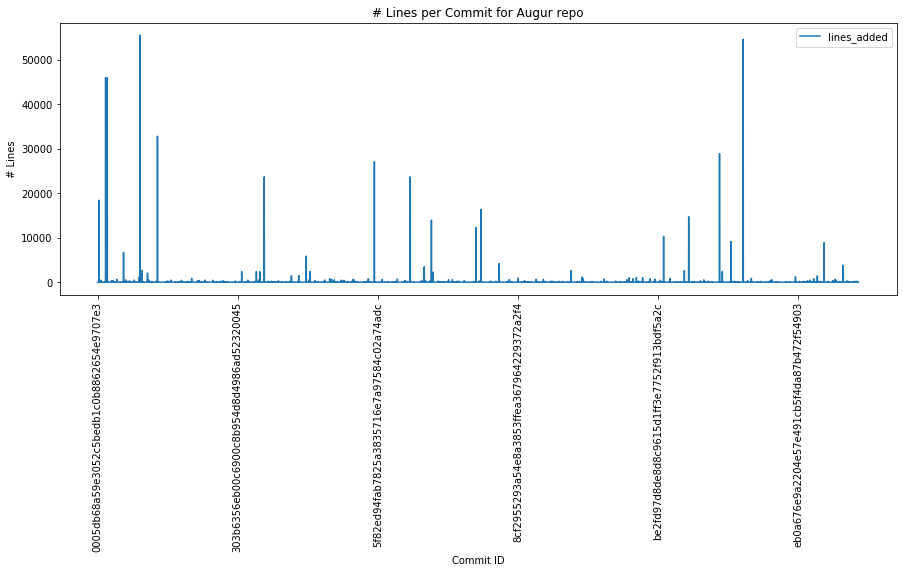

In [13]:
df_lines_augur.plot()

plt.xlabel("Commit ID")
plt.ylabel("# Lines")
plt.title("# Lines per Commit for Augur repo")
plt.xticks(rotation=90)
plt.show()

### Number of lines/commits/file 

## Query for issues analysis
 

In [14]:
df_issues = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    r.repo_name,
					i.issue_id AS issue, 
					i.gh_issue_number AS issue_number,
					i.gh_issue_id AS gh_issue,
					i.created_at AS created, 
					i.closed_at AS closed
                FROM
                	repo r,
                    issues i
                WHERE
                	r.repo_id = i.repo_id AND
                    i.repo_id = \'{repo_id}\'
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_issues = pd.concat([df_issues, df_current_repo])

df_issues = df_issues.reset_index()
df_issues.drop("index", axis=1, inplace=True)
        
df_issues

,repo_name,issue,issue_number,gh_issue,created,closed
0,augur,340115,28,213149529,2017-03-09 20:06:18,2017-04-07 21:18:01
1,augur,343231,886,682259157,2020-08-20 00:09:30,2020-08-20 00:16:50
2,augur,343216,880,679627659,2020-08-15 19:11:45,2020-08-17 14:30:04
3,augur,343467,967,724668885,2020-10-19 14:21:08,2020-10-19 14:21:34
4,augur,342738,740,628534692,2020-06-01 15:34:33,2020-08-20 10:48:14
...,...,...,...,...,...,...
1855,grimoirelab,735294,437,941801983,2021-07-12 08:23:29,2021-07-28 08:58:49
1856,grimoirelab,735295,436,924259145,2021-06-17 19:24:54,NaT
1857,grimoirelab,340606,284,559853733,2020-02-04 17:00:31,NaT
1858,grimoirelab,734649,429,889819068,2021-05-12 08:28:28,NaT


### Numer of issues created (by hour/day/week)

In [15]:
# Fetch the commits for the `augur` repo
df_issues_augur = df_issues[df_issues['repo_name'] == 'augur']
df_issues_augur = df_issues_augur.reset_index(drop=True)

In [16]:
df_issues_augur.head()

,repo_name,issue,issue_number,gh_issue,created,closed
0,augur,340115,28,213149529,2017-03-09 20:06:18,2017-04-07 21:18:01
1,augur,343231,886,682259157,2020-08-20 00:09:30,2020-08-20 00:16:50
2,augur,343216,880,679627659,2020-08-15 19:11:45,2020-08-17 14:30:04
3,augur,343467,967,724668885,2020-10-19 14:21:08,2020-10-19 14:21:34
4,augur,342738,740,628534692,2020-06-01 15:34:33,2020-08-20 10:48:14


In [17]:
# find the number of issues created daily
df_issues_count = df_issues_augur.groupby(df_issues_augur['created'].dt.date).size().reset_index(name='Count')
df_issues_count

,created,Count
0,2017-01-20,3
1,2017-01-23,2
2,2017-01-25,1
3,2017-01-26,1
4,2017-01-30,1
...,...,...
617,2021-08-12,1
618,2021-08-13,6
619,2021-08-15,1
620,2021-08-16,3


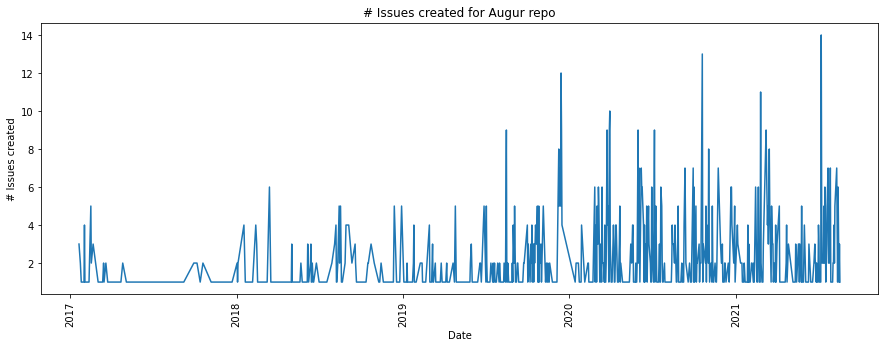

In [18]:
plt.plot(df_issues_count['created'],df_issues_count['Count'])
plt.xlabel("Date")
plt.ylabel("# Issues created")
plt.title("# Issues created for Augur repo")
plt.xticks(rotation=90)
plt.show()

### Numer of issues closed (by hour/day/week)

In [19]:
# find the number of issues closed daily
df_issues_closed_count = df_issues_augur.groupby(df_issues_augur['closed'].dt.date).size().reset_index(name='Count')
df_issues_closed_count

,closed,Count
0,2017-01-23,1
1,2017-01-27,1
2,2017-01-31,1
3,2017-02-02,6
4,2017-02-14,1
...,...,...
492,2021-08-12,1
493,2021-08-13,2
494,2021-08-15,1
495,2021-08-16,1


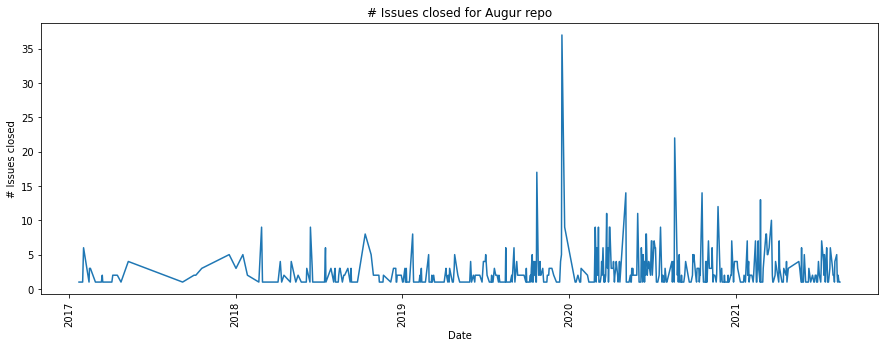

In [20]:
plt.plot(df_issues_closed_count['closed'],df_issues_closed_count['Count'])
plt.xlabel("Date")
plt.ylabel("# Issues closed")
plt.title("# Issues closed for Augur repo")
plt.xticks(rotation=90)
plt.show()

### Numer of issues open (by hour/day/week)

## Query for Pull Request Analysis

In [21]:
df_pr = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    r.repo_name,
					i.issue_id AS issue, 
					i.gh_issue_number AS issue_number,
					i.gh_issue_id AS gh_issue,
					i.created_at AS created, 
					i.closed_at AS closed
                FROM
                	repo r,
                    pulll_request i
                WHERE
                	r.repo_id = pr.repo_id AND
                    r.repo_id = \'{repo_id}\'
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_pr = pd.concat([df_pr, df_current_repo])

df_pr = df_pr.reset_index()
df_pr.drop("index", axis=1, inplace=True)
        
df_pr

ProgrammingError: (psycopg2.errors.UndefinedTable) relation "pulll_request" does not exist
LINE 11:                     pulll_request i
                             ^

[SQL: 
                SELECT
                    r.repo_name,
					i.issue_id AS issue, 
					i.gh_issue_number AS issue_number,
					i.gh_issue_id AS gh_issue,
					i.created_at AS created, 
					i.closed_at AS closed
                FROM
                	repo r,
                    pulll_request i
                WHERE
                	r.repo_id = pr.repo_id AND
                    r.repo_id = '25440'
        ]
(Background on this error at: https://sqlalche.me/e/14/f405)

### Numer of PRs created (by hour/day/week)

### Numer of PRs closed (by hour/day/week)

### Numer of PRs open (by hour/day/week)

### Number of Reviews started/closed (by hour/day/week)

### Number of repositories

### Number of assignees

### Commits 